# Data analysis HD blastwave

Import libraries to import data and plot it

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

Increase rsolution of plots

In [2]:
mpl.rcParams["figure.dpi"] = 150    # about the dpi for a 15 inch 1080p laptop, makes sure the displayed plots are the real size 
#mpl.rcParams["figure.dpi"] = 600

mpl.rcParams["figure.figsize"] = (6, 3)
mpl.rcParams["axes.labelsize"] = 12

mpl.rcParams["axes.formatter.limits"] = (-4, 4)

color=["xkcd:royal blue", "xkcd:vermillion", "xkcd:orange", 
       "xkcd:magenta", "xkcd:lime", "xkcd:yellow", "grey"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color)
mpl.rcParams["lines.linewidth"] = .75
mpl.rcParams["axes.linewidth"] = .5

mpl.rcParams["font.size"] = 10

mpl.rcParams["text.usetex"] = True


#mpl.rcParams["figure.facecolor"] = "#fffbf0"
#mpl.rcParams["axes.facecolor"] = "#fffbf0"
#mpl.rcParams["savefig.facecolor"] = '#fffbf0'

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

## get metadata of the simulation data

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR_1 = "data/25d-low-pressure/"
DATA_DIR_2 = "data/25d-high-pressure/"
DATA_DIR_3 = "data/25d-ulow/"
OUT_DIR = "images/"

# define the conversion factors, can be seen when starting the simulation
UNIT_DENSITY = 1e9*CONST_mp
UNIT_LENGTH = 1e8 # cm (1AU)
UNIT_VELOCITY = 1e8 # cm/s
UNIT_TIME = UNIT_LENGTH/UNIT_VELOCITY
UNIT_PRESSURE = 1.673e1   # dyne/cm^2

In [5]:
# get info about the stored data
file_data = pd.read_csv(DATA_DIR_1+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR_1+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR_1+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

# physical extent of the grid
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH for value in extent_temp]
# physical time data
T = file_data["t"].values*UNIT_TIME

## Calculate wave speed

Get the distance on different times

In [6]:
THETA = np.linspace(0, 2*np.pi, 120, endpoint=False)
circle = (X_POINTS-1)/2+np.array([[np.cos(theta), np.sin(theta)] for theta in THETA])*(X_POINTS/2-10)

BACKGROUND_PRS = 1.0
mult = 1.05

dist_arr_1 = []
max_prs_1 = []
dist_arr_2 = []
max_prs_2 = []
dist_arr_3 = []
max_prs_3 = []

for i in range(51):
    D1 = pp.pload(i, w_dir=DATA_DIR_1)
    D2 = pp.pload(i, w_dir=DATA_DIR_2)
    D3 = pp.pload(i, w_dir=DATA_DIR_3)
    coord_arr_1 = []
    coord_arr_2 = []
    coord_arr_3 = []
    # loop over all directions
    for point in circle:
        direction = (point-X_POINTS/2)/X_POINTS
        
        # find value for low pressure
        val = 0
        step = 0
        # loop over all points in this direction until the center is reached, or a point
        # with prs > 1.05*background is found
        while step <= X_POINTS and val < mult*BACKGROUND_PRS:
            coordinate = point - direction*step
            val = D1.prs[int(coordinate[0]), int(coordinate[1])]
            step += 1
        coord_arr_1.append([int(coordinate[0]), int(coordinate[1])])
        
        # find value for high pressure
        val = 0
        step = 0
        # loop over all points in this direction until the center is reached, or a point
        # with prs > 1.05*background is found
        while step <= X_POINTS and val < mult*BACKGROUND_PRS:
            coordinate = point - direction*step
            val = D2.prs[int(coordinate[0]), int(coordinate[1])]
            step += 1
        coord_arr_2.append([int(coordinate[0]), int(coordinate[1])])
        
        # find value for high pressure
        val = 0
        step = 0
        # loop over all points in this direction until the center is reached, or a point
        # with prs > 1.05*background is found
        while step <= X_POINTS and val < 1.005*BACKGROUND_PRS:
            coordinate = point - direction*step
            val = D3.prs[int(coordinate[0]), int(coordinate[1])]
            step += 1
        coord_arr_3.append([int(coordinate[0]), int(coordinate[1])])
        
    # calculate the distances
    wave_front = np.array(coord_arr_1) - (X_POINTS-1)/2
    dist_arr_1.append( np.sqrt(wave_front[:,0]**2 + wave_front[:,1]**2) )
    max_prs_1.append(np.max(D1.prs))
    wave_front = np.array(coord_arr_2) - (X_POINTS-1)/2
    dist_arr_2.append( np.sqrt(wave_front[:,0]**2 + wave_front[:,1]**2) )
    max_prs_2.append(np.max(D2.prs))
    wave_front = np.array(coord_arr_3) - (X_POINTS-1)/2
    dist_arr_3.append( np.sqrt(wave_front[:,0]**2 + wave_front[:,1]**2) )
    max_prs_3.append(np.max(D3.prs))
    
dists1 = np.array(dist_arr_1)
dists2 = np.array(dist_arr_2)
dists3 = np.array(dist_arr_3)

Reading Data file : data/25d-low-pressure/data.0000.dbl
Reading Data file : data/25d-high-pressure/data.0000.dbl
Reading Data file : data/25d-ulow/data.0000.dbl
Reading Data file : data/25d-low-pressure/data.0001.dbl
Reading Data file : data/25d-high-pressure/data.0001.dbl
Reading Data file : data/25d-ulow/data.0001.dbl
Reading Data file : data/25d-low-pressure/data.0002.dbl
Reading Data file : data/25d-high-pressure/data.0002.dbl
Reading Data file : data/25d-ulow/data.0002.dbl
Reading Data file : data/25d-low-pressure/data.0003.dbl
Reading Data file : data/25d-high-pressure/data.0003.dbl
Reading Data file : data/25d-ulow/data.0003.dbl
Reading Data file : data/25d-low-pressure/data.0004.dbl
Reading Data file : data/25d-high-pressure/data.0004.dbl
Reading Data file : data/25d-ulow/data.0004.dbl
Reading Data file : data/25d-low-pressure/data.0005.dbl
Reading Data file : data/25d-high-pressure/data.0005.dbl
Reading Data file : data/25d-ulow/data.0005.dbl
Reading Data file : data/25d-low-p

### Fit lines through array of distances

In [7]:
vs = np.sqrt(5/3)

In [9]:
speeds1 = [[], [], []]
speeds2 = [[], [], []]
speeds3 = [[], [], []]
TIME = 10
h = 0.03


def centr_diff2(f,h):
    """"Calculates the central difference wich converges as O(h^2)
    x,y: array with 3 entries"""
    return (f[2]-f[0])/(2*h)

def centr_diff4(f,h):
    return (-f[4]+8*f[3]-8*f[1]+f[0])/(12*h)

for j in range(3):
    for i in range(len(THETA)):
        Y = dists1[TIME-1+j:TIME+2+j,i]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed = centr_diff2(Y,h) 

        speeds1[j].append( speed )

    for i in range(len(THETA)):
        Y = dists2[TIME+j-1:TIME+j+2,i]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed = centr_diff2(Y,h) 

        speeds2[j].append( speed )

    for i in range(len(THETA)):
        Y = dists3[TIME+j-1:TIME+j+2,i]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed = centr_diff2(Y,h) 

        speeds3[j].append( speed )

In [10]:
speeds1 = np.array(speeds1)
speeds1 = sum([speeds1[i] for i in range(3)])/3
speeds2 = np.array(speeds2)
speeds2 = sum([speeds2[i] for i in range(3)])/3
speeds3 = np.array(speeds3)
speeds3 = sum([speeds3[i] for i in range(3)])/3

Snelheid gesimuleerde golf is bijna exact gelijk aan $$v_s = \sqrt{\gamma \frac{p_{min}+p_{max}}{2}}v_0 $$
met $p_{min}$ de lage druk rond de golf, $p_{max}$ de hoogste druk van de golf en $v_0$ de unit velocity voor de simulatie

### Calculate wavespeed with formula above

In [12]:
def shock_theory(min_prs, max_prs, rho=1, gamma=5/3):
    vs2 = gamma*min_prs/rho
    return np.sqrt(vs2 + (gamma+1)/(2*rho)*(max_prs-min_prs))

START = 10
STOP = 40
v_sim1 = []
v_theory1 = shock_theory(1, np.array(max_prs_1[START:STOP]))
v_sim2 = []
v_theory2 = shock_theory(1, np.array(max_prs_2[START:STOP]))
v_sim3 = []
v_theory3 = shock_theory(1, np.array(max_prs_3[START:STOP]))
h = 0.03


for i in range(START,STOP):
    speed_sum = 0
    for j in range(len(THETA)):
        # get the speed from the simulation using numerical differentiation
        Y = dists1[i-1:i+2,j]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed_sum += centr_diff2(Y,h)
    v_sim1.append( speed_sum/len(THETA) )
    
for i in range(START,STOP):
    speed_sum = 0
    for j in range(len(THETA)):
        # get the speed from the simulation using numerical differentiation
        Y = dists2[i-1:i+2,j]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed_sum += centr_diff2(Y,h)
    v_sim2.append( speed_sum/len(THETA) )
    
for i in range(START,STOP):
    speed_sum = 0
    for j in range(len(THETA)):
        # get the speed from the simulation using numerical differentiation
        Y = dists3[i-1:i+2,j]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)
        speed_sum += centr_diff2(Y,h)
    v_sim3.append( speed_sum/len(THETA) )

## combined plot

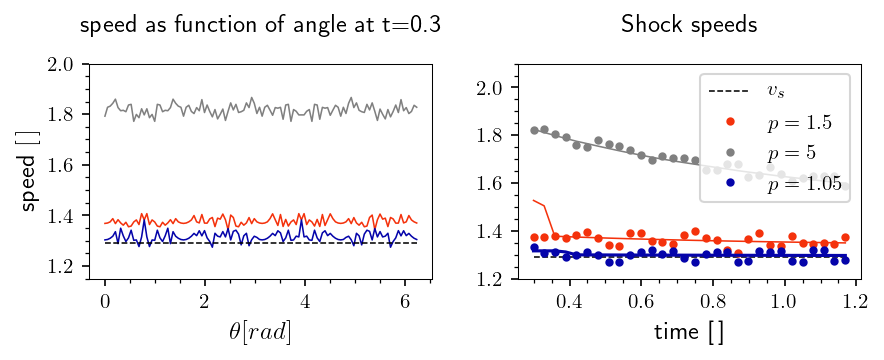

In [13]:
fig, ax = plt.subplots(1,2, figsize=(6,2.5))

axis = ax[0]
axis.plot(THETA, speeds2, label="high pressure", color=color[6])
axis.plot(THETA, speeds1, label="low pressure", color=color[1])
axis.plot(THETA, speeds3, label="ulow pressure", color=color[0])
axis.plot(THETA, np.ones_like(THETA)*vs, "--k", label=r"$v_s$")

axis.set_ylim(1.15,2)
axis.set_ylabel(r"speed $[\,]$")
axis.set_xlabel(r"$\theta [rad]$")
axis.set_title("speed as function of angle at t=%.1f"%T[TIME], pad=15)
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
#axis.legend(loc="upper right")


axis = ax[1]
axis.plot(T[START:STOP], np.ones_like(T[START:STOP])*vs, "--k", label="$v_s$")
axis.plot(T[START:STOP], v_sim1, ".", label="$p=1.5$", color=color[1])
axis.plot(T[START:STOP], v_theory1, color=color[1])
axis.plot(T[START:STOP], v_sim2, ".", label="$p=5$", color=color[6])
axis.plot(T[START:STOP], v_theory2, color=color[6])
axis.plot(T[START:STOP], v_sim3, ".", label="$p=1.05$", color=color[0])
axis.plot(T[START:STOP], v_theory3, color=color[0], lw=1.5)
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

axis.set_ylim(1.2,2.1)

axis.set_xlabel("time [\,]")
#axis.set_ylabel("speed [cm/s]")
axis.set_title("Shock speeds", pad=15)

axis.legend(loc="upper right")

plt.tight_layout()

fig.savefig("../verslag/images/HD-speed.pdf", dpi=300)